In [1]:
from toolbar.average_filter import nanmean_filter
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from cnmaps import get_adm_maps, draw_maps
from matplotlib import gridspec
from matplotlib import ticker, colors
import cmaps
from matplotlib.ticker import MultipleLocator
from sympy.printing.pretty.pretty_symbology import line_width

from toolbar.masked import masked   # 气象工具函数


CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
zone_stations = masked((CN051_2 - CN051_2 + 1).sel(time='2022-01-01'), r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").sum()['tmax'].data
Tmax_5Day_filt = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
T_th = 0.90
t95 = masked(Tmax_5Day_filt, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").quantile(T_th, dim=['year', 'day'])  # 夏季内 长江中下游流域 分位数
Tmax_5Day_filt_averTh = nanmean_filter(t95, 11)  # 11*11格点 空间滑动平均
EHD = Tmax_5Day_filt - 31.76166257
EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
EHD_0 = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")  # 掩膜处理得长江流域EHD温度距平

C:\Program Files (x86)\Anaconda3\lib\site-packages\xarray\coding\times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\Program Files (x86)\Anaconda3\lib\site-packages\xarray\coding\times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\Users\10574\AppData\Roaming\Python\Python39\site-packages\numpy\lib\nanfunctions.py:1563: R

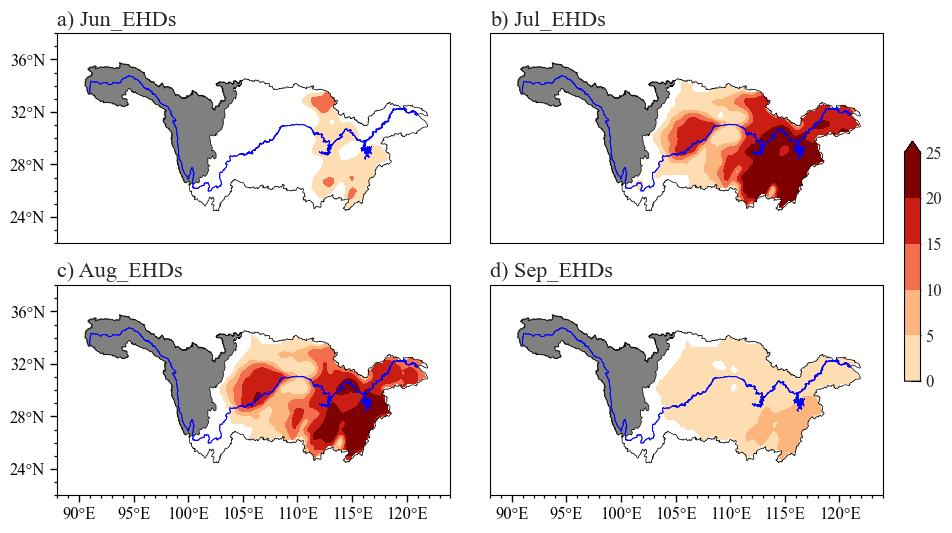

In [11]:
# 绘图
# ##地图要素设置
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
spec = gridspec.GridSpec(ncols=2, nrows=2, wspace=0.1, hspace=0.2)  # 设置子图比例
extent_CN = [88, 124, 22, 38]  # 中国大陆经度范围，纬度范围
proj = ccrs.PlateCarree()   # 投影方式

#ax1
# 读取CN05.1逐日最高气温数据
EHD = EHD_0  # 读取缓存
EHD = EHD.sel(day=EHD['day'].isin([str(i) for i in range(0, 30)])).sum('day').mean('year')
# 将0值替换为缺测值
EHD = EHD.where(EHD > 0)
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")
plt.rcParams['axes.edgecolor'] = 'black'
# 字体为新罗马
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(figsize=(10.66, 6))   # 创建画布
ax1 = fig.add_subplot(spec[0, 0], projection=proj)  # 添加子图
ax1.set_extent(extent_CN, crs=proj) # 设置地图范围
ax1.set_aspect('auto')  # 设置长宽比
ax1.set_title('a) Jun_EHDs', fontsize=16, loc='left')
level = [0, 5, 10, 15, 20, 25]  # 等值线间隔
custom_colors = ["#FFFFFF", "#FDDDB1", "#FDB57E", "#F26E4c", "#CA1E14", "#7F0000"]
custom_cmap = colors.ListedColormap(custom_colors)
a1 = ax1.contourf(EHD['lon'], EHD['lat'], EHD.data, cmap=custom_cmap, levels=level, extend='max', transform=proj)
# ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray')# 添加陆地并且陆地部分全部填充成浅灰色
ax1.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
ax1.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
ax1.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.6)
ax1.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江干流_lake\lake_wsg84.shp').geometries(), ccrs.PlateCarree(), facecolor='blue', edgecolor='blue', linewidth=0.2)
#ax1.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)


# 刻度线设置
xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
'''ax1.set_xticks(xticks1, crs=proj)'''
ax1.set_yticks(yticks1, crs=proj)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
'''ax1.xaxis.set_major_formatter(lon_formatter)'''
ax1.yaxis.set_major_formatter(lat_formatter)
'''xmajorLocator = MultipleLocator(5)#先定义xmajorLocator，再进行调用
ax1.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
xminorLocator = MultipleLocator(1)
ax1.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度'''
ymajorLocator = MultipleLocator(4)
ax1.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
yminorLocator = MultipleLocator(1)
ax1.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
# 调整刻度值字体大小
ax1.tick_params(axis='both', labelsize=12, colors='black')
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax1.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
ax1.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
ax1.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
ax1.grid(False)


# ax2
# 读取CN05.1逐日最高气温数据
EHD = EHD_0  # 读取缓存
EHD = EHD.sel(day=EHD['day'].isin([str(i) for i in range(30, 61)])).sum('day').mean('year')
# 将0值替换为缺测值
EHD = EHD.where(EHD > 0)
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")

ax2 = fig.add_subplot(spec[0, 1], projection=proj)  # 添加子图
ax2.set_extent(extent_CN, crs=proj) # 设置地图范围
ax2.set_aspect('auto')  # 设置长宽比
ax2.set_title('b) Jul_EHDs', fontsize=16, loc='left')
level = [0, 5, 10, 15, 20, 25]  # 等值线间隔
custom_colors = ["#FDDDB1", "#FDB57E", "#F26E4c", "#CA1E14", "#7F0000"]
custom_cmap = colors.ListedColormap(custom_colors)
a2 = ax2.contourf(EHD['lon'], EHD['lat'], EHD.data, cmap=custom_cmap, levels=level, extend='max', transform=proj)
# ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray')# 添加陆地并且陆地部分全部填充成浅灰色
ax2.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
ax2.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
ax2.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.6)
ax2.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江干流_lake\lake_wsg84.shp').geometries(), ccrs.PlateCarree(), facecolor='blue', edgecolor='blue', linewidth=0.2)
#ax2.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)

# 刻度线设置
xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
'''ax2.set_xticks(xticks1, crs=proj)'''
# ax2.set_yticks(yticks1, crs=proj)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
'''ax2.xaxis.set_major_formatter(lon_formatter)'''
ax2.yaxis.set_major_formatter(lat_formatter)
'''xmajorLocator = MultipleLocator(5)#先定义xmajorLocator，再进行调用
ax2.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
xminorLocator = MultipleLocator(1)
ax2.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度'''
ymajorLocator = MultipleLocator(4)
ax2.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
yminorLocator = MultipleLocator(1)
ax2.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
# 调整刻度值字体大小
ax2.tick_params(axis='both', labelsize=12, colors='black')
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax2.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
ax2.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
ax2.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
ax2.grid(False)


# ax3
# 读取CN05.1逐日最高气温数据
EHD = EHD_0  # 读取缓存
EHD = EHD.sel(day=EHD['day'].isin([str(i) for i in range(61, 92)])).sum('day').mean('year')
# 将0值替换为缺测值
EHD = EHD.where(EHD > 0)
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")

ax3 = fig.add_subplot(spec[1, 0], projection=proj)  # 添加子图
ax3.set_extent(extent_CN, crs=proj) # 设置地图范围
ax3.set_aspect('auto')  # 设置长宽比
ax3.set_title('c) Aug_EHDs', fontsize=16, loc='left')

level = [0, 5, 10, 15, 20, 25]  # 等值线间隔
custom_colors = ["#FDDDB1", "#FDB57E", "#F26E4c", "#CA1E14", "#7F0000"]
custom_cmap = colors.ListedColormap(custom_colors)
a3 = ax3.contourf(EHD['lon'], EHD['lat'], EHD.data, cmap=custom_cmap, levels=level, extend='max', transform=proj)
# ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray')# 添加陆地并且陆地部分全部填充成浅灰色
ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
ax3.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.6)
ax3.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江干流_lake\lake_wsg84.shp').geometries(), ccrs.PlateCarree(), facecolor='blue', edgecolor='blue', linewidth=0.2)

#ax3.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)

# 刻度线设置
xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
ax3.set_xticks(xticks1, crs=proj)
ax3.set_yticks(yticks1, crs=proj)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
xmajorLocator = MultipleLocator(5)#先定义xmajorLocator，再进行调用
ax3.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
xminorLocator = MultipleLocator(1)
ax3.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度
ymajorLocator = MultipleLocator(4)
ax3.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
yminorLocator = MultipleLocator(1)
ax3.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
# 调整刻度值字体大小
ax3.tick_params(axis='both', labelsize=12, colors='black')
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax3.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
ax3.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
ax3.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
ax3.grid(False)


# ax4
# 读取CN05.1逐日最高气温数据
EHD = EHD_0  # 读取缓存
EHD = EHD.sel(day=EHD['day'].isin([str(i) for i in range(92, 122)])).sum('day').mean('year')
# 将0值替换为缺测值
EHD = EHD.where(EHD > 0)
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")

ax4 = fig.add_subplot(spec[1, 1], projection=proj)  # 添加子图
ax4.set_aspect('auto')  # 设置长宽比
ax4.set_extent(extent_CN, crs=proj) # 设置地图范围
ax4.set_title('d) Sep_EHDs', fontsize=16, loc='left')

level = [0, 5, 10, 15, 20, 25]  # 等值线间隔
custom_colors = ["#FDDDB1", "#FDB57E", "#F26E4c", "#CA1E14", "#7F0000"]
custom_cmap = colors.ListedColormap(custom_colors)
a4 = ax4.contourf(EHD['lon'], EHD['lat'], EHD.data, cmap=custom_cmap, levels=level, extend='max', transform=proj)
# ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray')# 添加陆地并且陆地部分全部填充成浅灰色
ax4.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
ax4.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
ax4.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.6)
ax4.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江干流_lake\lake_wsg84.shp').geometries(), ccrs.PlateCarree(), facecolor='blue', edgecolor='blue', linewidth=0.2)

#ax4.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)

# 刻度线设置
xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
ax4.set_xticks(xticks1, crs=proj)
# ax4.set_yticks(yticks1, crs=proj)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
xmajorLocator = MultipleLocator(5)#先定义xmajorLocator，再进行调用
ax4.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
xminorLocator = MultipleLocator(1)
ax4.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度
ymajorLocator = MultipleLocator(4)
ax4.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
yminorLocator = MultipleLocator(1)
ax4.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
# 调整刻度值字体大小
ax4.tick_params(axis='both', labelsize=12, colors='black')
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax4.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
ax4.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
ax4.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
ax4.grid(False)


# color bar位置
# position = fig.add_axes([0.296, 0.08, 0.44, 0.011])#位置[x, y, w, h]
ax_cbar = fig.add_axes([0.92, 0.30, 0.015, 0.40])
cb4 = plt.colorbar(a4, orientation='vertical', cax=ax_cbar, aspect=30, shrink=.6)#orientation为水平或垂直
cb4.ax.tick_params(length=7, labelsize=12, color='black', direction='in')#length为刻度线的长度
tick_locator = ticker.FixedLocator([0, 5, 10, 15, 20, 25])  # colorbar上的刻度值个数

plt.savefig(r'D:\PyFile\p2\pic\图1.pdf', bbox_inches='tight')
plt.show()